In [1]:
from utils import set_working_directory_up_two_levels
set_working_directory_up_two_levels()

In [78]:
import matplotlib.pyplot as plt 

import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import os 

from glob import glob

from sklearn.metrics import confusion_matrix
import matplotlib.patheffects as PathEffects

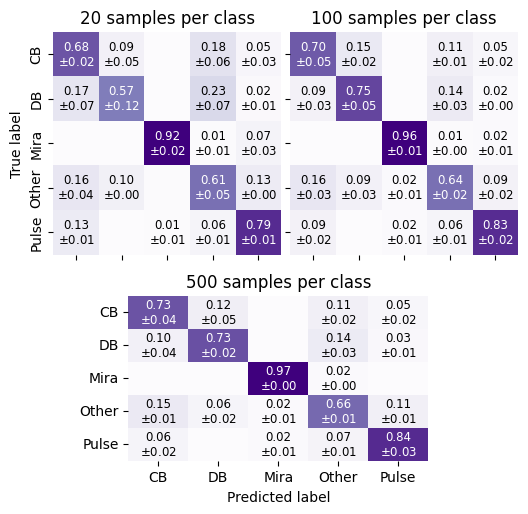

In [212]:
root = './presentation/results/diagstromer/2024-12-02_14-13-12/'

dataname = 'ATLAS'

atlas_labels = ['CB', 'DB', 'Mira', 'Other', 'Pulse']
alcock_labels = ['Cep_0', 'Cep_1', 'EC', 'LPV', 'RRab', 'RRc']
if dataname == 'Alcock':
    labels_ = alcock_labels
else:
    labels_ = atlas_labels


# Create the plot
if dataname == 'Alcock':
    # figsize=(5, 12)
    figsize=(7, 7)
    gridspec = {'hspace':-0.2, 'wspace':0.04}
if dataname == 'ATLAS':
    # figsize=(4, 12)
    figsize=(6, 5.5)
    gridspec = {'hspace':-0.1, 'wspace':0.04}
    
fig, axes =plt.subplots(2, 2, figsize=figsize, sharex=True, sharey=True, gridspec_kw=gridspec)
fig.delaxes(axes[1, 1])
axes[1, 0].set_position([0.25, 0.1, 0.5, 0.3])  # [left, bottom, width, height]
axes = axes.flatten()

for k, spc in enumerate([20, 100, 500]):
    paths = glob(os.path.join(root, 
                              'classification', 
                              dataname.lower(), '*', '*_{}'.format(spc), 'skip_avg_mlp', '*pkl'))
    
    confmatrices = []
    for p in paths:
        with open(p, 'rb') as handle:
            predictions = pickle.load(handle)
            y_true = np.argmax(predictions['true'], 1)
            y_pred = np.argmax(predictions['pred'], 1)
            cm = confusion_matrix(y_true, y_pred, normalize='true')
            confmatrices.append(cm)
    # MEAN METRICS
    confmatrices = np.array(confmatrices)
    mean_cm = np.mean(confmatrices, 0)
    std_cm    = np.std(confmatrices, 0)

    # PLOT 
    # Create heatmap
    ax = sns.heatmap(mean_cm, annot=False, fmt='d', cmap='Purples',
                     xticklabels=labels_, yticklabels=labels_, ax=axes[k], cbar=False)
    # Add annotations with median and percentiles
    for i in range(mean_cm.shape[0]):
        for j in range(mean_cm.shape[1]):
    
            mean_val = mean_cm[i, j]
            std_val = std_cm[i, j] 
            if mean_val < 0.01:
                text = r''
            else:
                # Format text as "median\n+upper\n-lower"
                text = "{:.2f}\n$\pm${:.2f}".format(mean_val, std_val)
            color='k'
            if i == j:
                color = 'w'
            
            txt = axes[k].text(j + 0.5, i + 0.5, text,
                    ha='center', va='center', color=color, fontsize=8.5)
            # # Add border effect to text
            # txt.set_path_effects([
            #     PathEffects.withStroke(
            #         linewidth=1,     # Width of the border
            #         foreground='w',  # Color of the border
            #         alpha=1
            #     )])
    # axes[k].set_xlabel('Predicted label')
    # axes[k].set_ylabel('True label')
    axes[k].set_title('{} samples per class'.format(spc))

axes[2].set_xlabel('Predicted label')
axes[0].set_ylabel('True label')

fig.savefig('./presentation/figures/classification/{}_cm.pdf'.format(dataname.lower()), format='pdf', bbox_inches='tight', dpi=300)

In [201]:
metadata = pd.read_parquet('./data/records/{}/100/metadata.parquet'.format(dataname.lower()))
if dataname == 'Alcock':
    metadata = metadata[metadata['Class']!='UNK'][['Class', 'Label']]
if dataname == 'ATLAS':
    # metadata = metadata[metadata['Class']!='Dubi'][['Class', 'Label']]
    pass
labels = {}
for u in metadata['Class'].unique():
    label = metadata[metadata['Class'] == u]['Label'].iloc[0]
    labels[label] = u
labels

{3: 'LPV', 0: 'Cep_0', 4: 'RRab', 5: 'RRc', 2: 'EC', 1: 'Cep_1'}

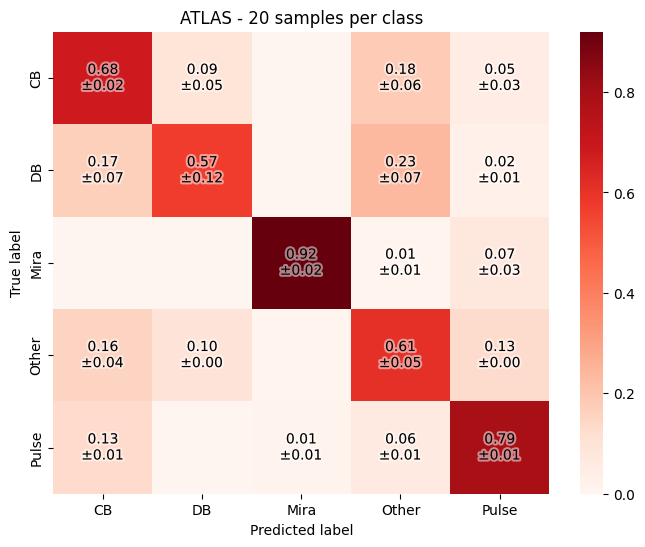